<a href="https://colab.research.google.com/github/Bensong0506/Deep-learning/blob/main/simulation_gpu_numerical_twolayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import random
import pylab
import scipy.stats as stats
from scipy.stats import normaltest
import seaborn as sns
%matplotlib inline

from mpl_toolkits import mplot3d
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
#torch.manual_seed(10)
n_data = 10000
x1 = np.random.uniform(-1,1,n_data) 
x2 = np.random.uniform(-1,1,n_data) 
x3 = np.ones(n_data)

#x2 = np.random.uniform(-1,1,n_data) 
x = np.stack((x1, x2, x3))# x data (tensor), shape=(100, 2)

In [ ]:
x.shape

(3, 10000)

In [ ]:
#generate the target function
n1 = 2000
def sigmas(x):
    return np.maximum(x, 0)

#generate normal distribution
mu, sigma = 0, 1 # mean and standard deviation
np.random.seed(10)
wk = np.random.normal(mu, sigma, len(x)*n1).reshape((n1,len(x)))
print(wk.shape)
#wk = np.random.gamma(2.0, 2.0, 2*n1).reshape((n1,2))
#wk = np.random.poisson(5, 2*n1).reshape((n1,2))

#function generate for a from R^d to R.
def functiona(x):
    return x[0] ** 2 + x[1]** 2

def functionf(w, x):
    w  = w / np.linalg.norm(w, ord=1, axis = 1).reshape((len(w),1))
    sums = np.apply_along_axis(functiona, 1, w) @ sigmas(w@x)
    return sums / len(w)

fx = functionf(wk, x)

print(fx.shape)
print(fx)
print(x[0,:])

(2000, 3)
(10000,)
[0.07616256 0.0815641  0.06326191 ... 0.06112085 0.06100579 0.05455527]
[ 0.65217394  0.81720762  0.14243076 ... -0.8359342  -0.18559331
 -0.25180595]


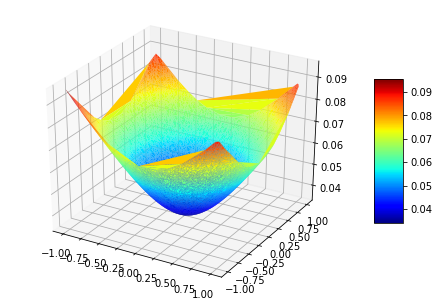

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(x[0,:], x[1,:], fx, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

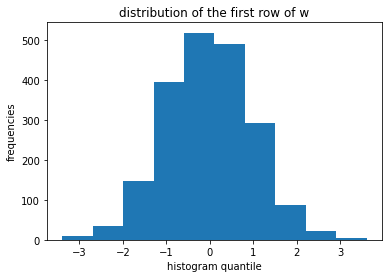

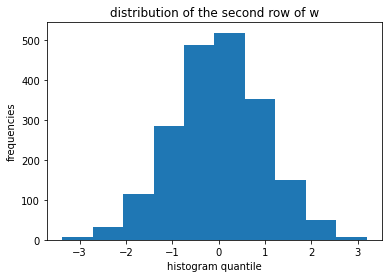

In [ ]:
plt.hist(wk[:,0])
plt.xlabel('histogram quantile')
plt.ylabel('frequencies')
plt.title("distribution of the first row of w")
plt.show()

plt.hist(wk[:,1])
plt.xlabel('histogram quantile')
plt.ylabel('frequencies')
plt.title("distribution of the second row of w")
plt.show()

In [ ]:
#neural network
X = torch.from_numpy(x.T).cuda()
Y = torch.from_numpy(fx.reshape((len(fx),1))).cuda()

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, shuffle=False)
print(x_train.shape)
print(y_train.shape)

torch.Size([8000, 3])
torch.Size([8000, 1])


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)             # linear output
        return x

def train(epochs, x_train, y_train):
    train_losses = []
    test_losses = []
  
    #early_stopping = EarlyStopping(patience=200, verbose=True)
    for i in range(epochs):
        i+=1
        y_pred = net(x_train.float())
        loss = loss_func(y_pred, y_train.float())
        if i%10 == 1 and i > 10:
            train_losses.append(loss.detach().cpu().numpy() * epochs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_val = net.forward(x_test.float())
            loss_2 = loss_func(y_val, y_test)
            if i%10 == 1 and i > 100:
                test_losses.append(loss_2.detach().cpu().numpy()* epochs)
        
        #early_stopping(test_losses, net)
        #scheduler.step()
        #if early_stopping.early_stop:
        #    print("Early stopping")
        #    break
        

        if i%500 == 1:
            print(f'epoch: {i:2}  loss_train: {loss.item() * epochs:10.8f} loss_test: {loss_2.item() * epochs:10.8f}')

    #net.load_state_dict(torch.load('checkpoint.pt'))
    return y_pred, train_losses, test_losses

In [ ]:
m = 200
net = Net(n_feature=len(x), n_hidden=m, n_output=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)
net = net.cuda()

In [ ]:
y_pred, train_losses, test_losses = train(20000, x_train, y_train)

epoch:  1  loss_train: 192.13771448 loss_test: 2935.97404675
epoch: 501  loss_train: 0.03986021 loss_test: 0.04004734
epoch: 1001  loss_train: 0.01249263 loss_test: 0.01274512
epoch: 1501  loss_train: 0.00653887 loss_test: 0.00659969
epoch: 2001  loss_train: 0.02142941 loss_test: 0.02039902
epoch: 2501  loss_train: 0.00403022 loss_test: 0.00415350
epoch: 3001  loss_train: 0.00689057 loss_test: 0.00745090
epoch: 3501  loss_train: 0.00262967 loss_test: 0.00284044
epoch: 4001  loss_train: 0.00291143 loss_test: 0.00300553
epoch: 4501  loss_train: 0.00302178 loss_test: 0.00307920
epoch: 5001  loss_train: 0.06702192 loss_test: 0.06748195
epoch: 5501  loss_train: 0.00120006 loss_test: 0.00120484
epoch: 6001  loss_train: 0.00200611 loss_test: 0.00195061
epoch: 6501  loss_train: 0.00071059 loss_test: 0.00072070
epoch: 7001  loss_train: 0.00058352 loss_test: 0.00056660
epoch: 7501  loss_train: 0.00066589 loss_test: 0.00074542
epoch: 8001  loss_train: 0.00089498 loss_test: 0.00089356
epoch: 8501 

In [ ]:
fx_hat = y_pred.detach().cpu().numpy()
fx_hat = fx_hat.reshape(len(x_train))
for name, param in net.named_parameters():
    if param.requires_grad:
        if name == 'hidden.weight':
            hidden_weight = param.data.detach().cpu().numpy()
        if name == 'out.weight':
            out_weight = param.data.detach().cpu().numpy()
        

#print("hidden_weights", hidden_weight)
#print("out_weights", out_weight)
print("hidden")
print(np.mean(hidden_weight,axis = 0))
print(np.std(hidden_weight,axis = 0))
print("output")
print(np.mean(out_weight))
print(np.std(out_weight))


#rescale hidden weights
#hidden_weight = (hidden_weight) / np.mean(np.std(hidden_weight,axis = 0))
#out_weight = out_weight * np.mean(np.std(hidden_weight,axis = 0))

hidden
[-0.00092398  0.01262638 -0.14617479]
[0.19063552 0.19712725 0.2803434 ]
output
0.002892983
0.018512076


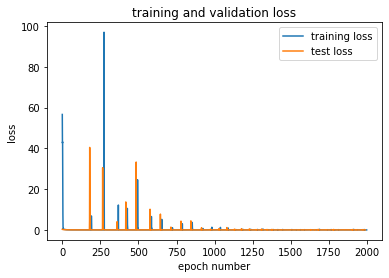

In [ ]:
# For Sine Function
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch number')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()

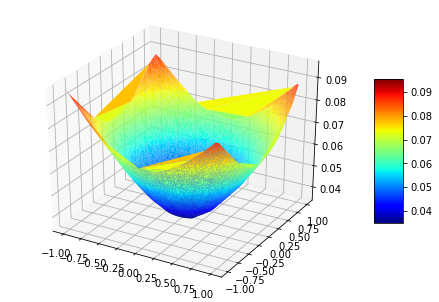

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(x_train.detach().cpu().numpy()[:,0], x_train.detach().cpu().numpy()[:,1], y_pred.detach().cpu().numpy().reshape(8000,), cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

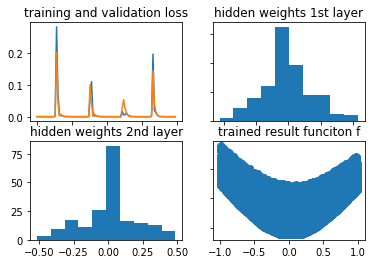

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(train_losses[-100:])
axis[0, 0].plot(test_losses[-100:])
axis[0, 0].set_title('training and validation loss')
  
# For Cosine Function
axis[0, 1].hist(hidden_weight[:,0])
axis[0, 1].set_title("hidden weights 1st layer")
  
# For Tangent Function
axis[1, 0].hist(hidden_weight[:,1])
axis[1, 0].set_title("hidden weights 2nd layer")
  
# For Tanh Function
axis[1, 1].scatter(x_train.detach().cpu().numpy()[:,0],y_pred.detach().cpu().numpy())
#axis[1, 1].plot(sorted(y_pred.detach().cpu().numpy()))
axis[1, 1].set_title("trained result funciton f")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()
  
# Combine all the operations and display
plt.show()

Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=1.101, p=0.577
Sample looks Gaussian (fail to reject H0)


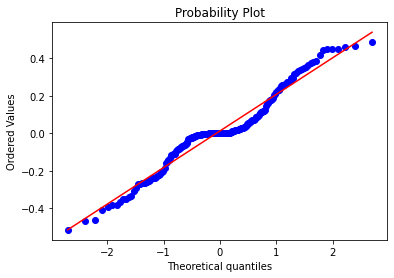

mean 0.012626377
standard deviation 0.19712722


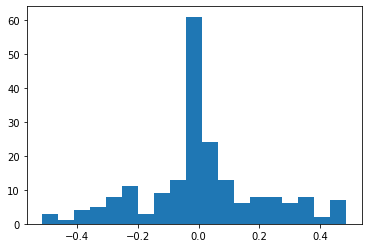

In [ ]:
from scipy.stats import shapiro

n= 1

# normality test
stat, p = shapiro(hidden_weight[:,n])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

stat, p = normaltest(hidden_weight[:,n])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

bins = np.linspace(hidden_weight[:,n].min(), hidden_weight[:,n].max(), 20)
stats.probplot(hidden_weight[:,n], dist = "norm", plot = pylab)
pylab.show()
plt.hist(hidden_weight[:,n], bins)

mean, std = np.mean(hidden_weight[:,n]) , np.std(hidden_weight[:,n])
print("mean", mean)
print("standard deviation", std)

In [ ]:
#rescale hidden weights
hidden_weight = (hidden_weight) / np.std(hidden_weight,axis = 0)

print(np.std(hidden_weight,axis = 0))

out_weight = out_weight / np.std(out_weight)



print(np.std(out_weight))

[0.99999976 0.9999994  0.99999946]
1.0


(200,)
(200, 3)


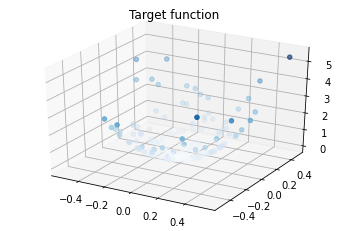

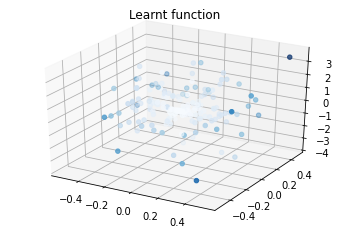

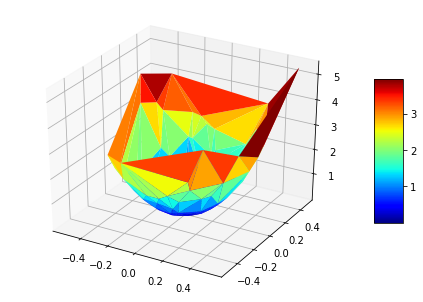

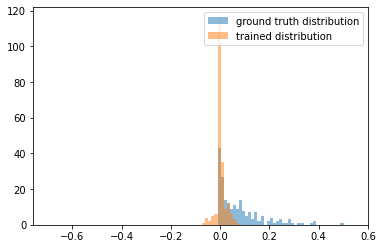

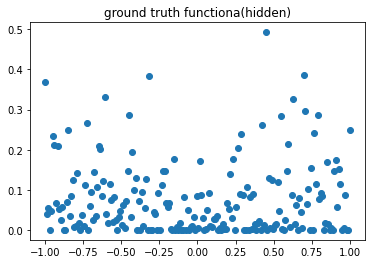

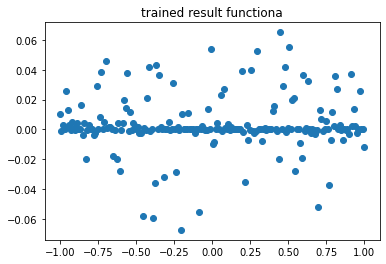

mean square error [0.01389538]


In [ ]:
def checkoutput(hidden_weights):
    output = np.apply_along_axis(functiona, 1, hidden_weights)
    return output

#hidden_weight = (hidden_weight - np.mean(hidden_weight,axis = 0)) / np.std(hidden_weight, axis = 0)
output = checkoutput(hidden_weight)
print(output.shape)
print(hidden_weight.shape)
x_index = np.linspace(-1,1,len(output))
x_index2 = np.linspace(-1,1,len(out_weight))
bins = np.linspace(hidden_weight.min(), hidden_weight.max(), 100)

ax = plt.axes(projection='3d')
ax.scatter3D(hidden_weight[:,0], hidden_weight[:,1], output/np.std(output), c=output, cmap='Blues')
ax.set_title("Target function")
plt.show()

ax = plt.axes(projection='3d')
ax.scatter3D(hidden_weight[:,0], hidden_weight[:,1], out_weight/np.std(out_weight), c=output, cmap='Blues')
ax.set_title("Learnt function")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(hidden_weight[:,0], hidden_weight[:,1], output/np.std(output), cmap=cm.jet, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

plt.hist(output, bins, alpha=0.5, label='ground truth distribution')
plt.hist(out_weight.T, bins, alpha=0.5, label='trained distribution')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_index, output)
plt.title("ground truth functiona(hidden)")
plt.show()
plt.scatter(x_index, out_weight)
plt.title("trained result functiona")
plt.show()

print("mean square error", ((out_weight - output)**2).mean(axis=1))

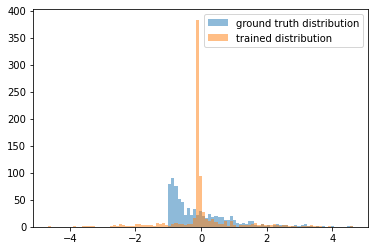

In [ ]:
out_weight = (out_weight - np.mean(out_weight)) / np.std(out_weight)
output = (output - np.mean(output)) / np.std(output)
bins = np.linspace(out_weight.min(), out_weight.max(), 100)

plt.hist(output, bins, alpha=0.5, label='ground truth distribution')
plt.hist(out_weight.T, bins, alpha=0.5, label='trained distribution')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#calculate the bound
#normalized wk
n2 = 2000
wk = np.random.normal(mu, sigma, 2*n2).reshape((n2,2))
    
def gamma2square(w):
    sums = 0
    w  = w / np.linalg.norm(w, ord=1, axis = 1).reshape((len(w),1))
    sums = np.apply_along_axis(functiona, 1, w) ** 2
    return np.sum(sums)/len(w)

gamma2 = gamma2square(wk)
print("gammasaqure", gamma2)

#number of hidden layer of nueral network
bound_func = gamma2 * 3/m
print("bound_func", bound_func)
bound_para = 2 * np.sqrt(gamma2)

gammasaqure 0.43044744335027196
bound_func 0.0016141779125635198


In [ ]:
#define loss functions
def loss(f,f_hat):
    return np.sum((f-f_hat)**2) / len(f)

def thetahatp(a,w):
    return np.sum(abs(a) @ np.linalg.norm(w, ord=1, axis = 1))

fx1 = fx[:len(fx_hat)]

loss = loss(fx1,fx_hat)
print("function loss is ", loss)
print("function bound is ", bound_func)

parameter = thetahatp(out_weight, hidden_weight)

print("parameter loss is ", parameter / np.sqrt(n_data))
print("parameter bound is ", bound_para)

function loss is  6.044429750186901e-08
function bound is  0.0016141779125635198
parameter loss is  0.0427501106262207
parameter bound is  1.3121698721587414
